## Initial plots

In [1]:
# this is just a script to plot the figures that will be used in the paper
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

sns.set_style('darkgrid')

fitness_names = ["mean_soja", "std_soja", "total_surface"]
names2labels = {fitness_names[0] : "Mean yearly soybean yield (tons)",
                fitness_names[1] : "Inter-year variance (tons)",
                fitness_names[2] : "Total surface allocated to soybeans (ha)"}

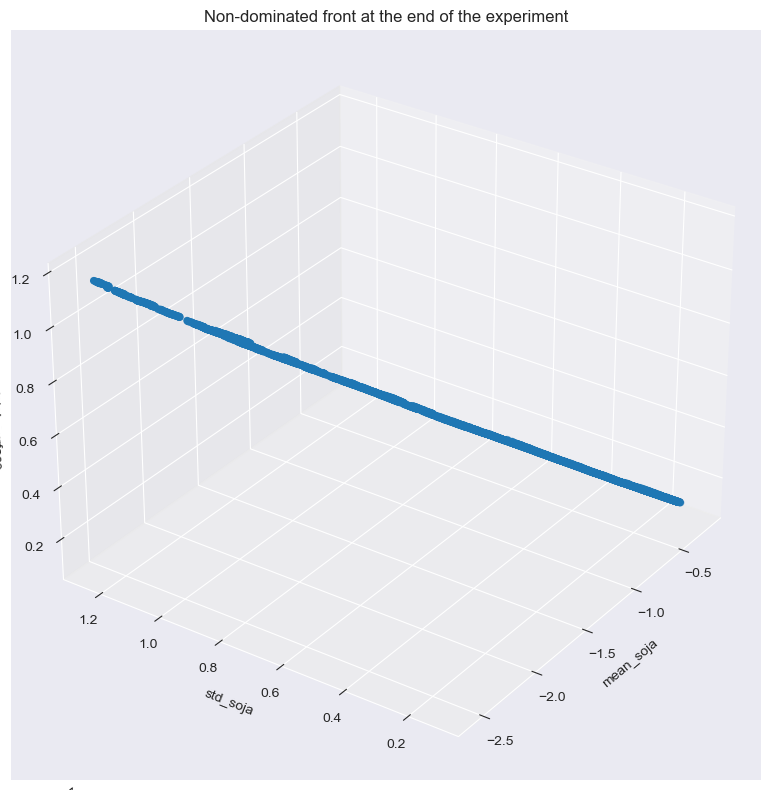

In [3]:
# let's start with something simple: we plot the final Pareto front from one of the experiments
#data_file = "../results/2024-01-19-soja-allocation-3-objectives/42-archive-generation-520.csv"

generation = 390
folder = "2024-01-26-soja-allocation-3-objectives"
data_file = "../results/" + folder + "/42-3-objectives-archive-generation-%d.csv" % generation

#data_file = "../results/3-objectives-42-archive-generation-1012.csv"
df = pd.read_csv(data_file)

x = df[fitness_names[0]].values
y = df[fitness_names[1]].values
z = df[fitness_names[2]].values

fig = plt.figure(figsize=(10, 8))
axes = plt.axes(projection="3d")
axes.scatter3D(x, y, z)

axes.set_title("Non-dominated front at the end of the experiment")
axes.set_xlabel(fitness_names[0])
axes.set_ylabel(fitness_names[1])
axes.set_zlabel(fitness_names[2])

axes.view_init(30, 215)
plt.tight_layout()
plt.show()

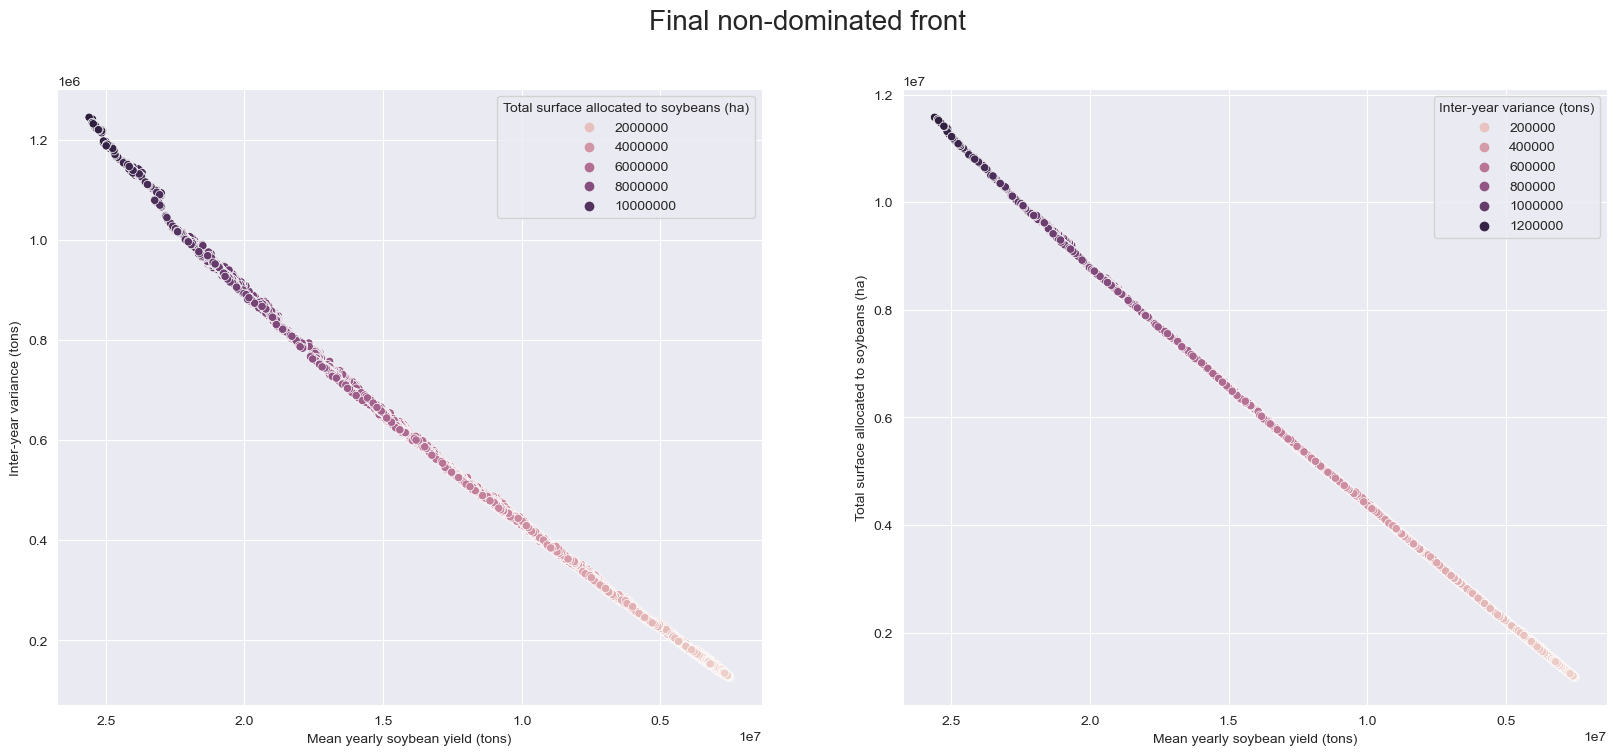

In [4]:
# now, here I need to perform some dark magic to avoid issues with labels
df_dictionary = {names2labels[fitness_names[i]] : [] for i in range(0, len(fitness_names))}


df_dictionary[names2labels[fitness_names[0]]] = df[fitness_names[0]].values * -1.0
df_dictionary[names2labels[fitness_names[1]]] = df[fitness_names[1]].values
df_dictionary[names2labels[fitness_names[2]]] = df[fitness_names[2]].values

df2 = pd.DataFrame.from_dict(df_dictionary)

# this plot kinda sucks, though; maybe it's better to have two plots side by side
fig = plt.figure(figsize=(20, 8))
ax1 = fig.add_subplot(121) # 1x2 grid, 1st subplot
ax2 = fig.add_subplot(122) # 1x2 grid, 2nd subplot

sns.scatterplot(data=df2, x=df2.columns[0], y=df2.columns[1], hue=df2.columns[2], ax=ax1)
ax1.invert_xaxis()
sns.scatterplot(data=df2, x=df2.columns[0], y=df2.columns[2], hue=df2.columns[1], ax=ax2)
ax2.invert_xaxis()

fig.suptitle("Final non-dominated front", fontsize=20)

plt.savefig("../results/" + folder + "-gen%d.png" % generation, dpi=300)

In [8]:
# this code here is just to check the file
row_max_soja = df.iloc[df["mean_soja"].idxmin()]
print(df["mean_soja"].idxmin(), row_max_soja)

13898 generation       1.012000e+03
mean_soja       -6.095014e+07
std_soja         4.092264e+06
total_surface    2.522683e+07
gene_0           3.095742e-01
                     ...     
gene_3504                 NaN
gene_3505                 NaN
gene_3506                 NaN
gene_3507                 NaN
gene_3508                 NaN
Name: 13898, Length: 3513, dtype: float64


In [14]:
# this is just a check to see if everything works properly and that the predictions are coherent
data_file = "../data/soybean_pred_2000_2023_avg.m_s20.csv"
df = pd.read_csv(data_file, sep=";", decimal=",") # unfortunately in European format
selected_columns = [c for c in df.columns if c.startswith("2")] # get year columns, like 2001, ..., 2017
print("Data file \"%s\" seems to include predictions for years %s..." % 
            (data_file, str(selected_columns)))
model_predictions = df[selected_columns].values

Data file "../data/soybean_pred_2000_2023_avg.m_s20.csv" seems to include predictions for years ['2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022', '2023']...


In [19]:
import numpy as np
candidate_solution_all_ones = np.ones((model_predictions.shape[0],))
max_cropland_area_percentage_usable = 0.2
max_cropland_area = df["cropland_area_ha"].values * max_cropland_area_percentage_usable

args = {"model_predictions" : model_predictions, "max_cropland_area" : max_cropland_area}

def fitness_function(individual, args) : 
    """
    This is the fitness function. It should be replaced by the 'true' fitness function to be optimized.
    """
    # load data
    model_predictions = args["model_predictions"]
    max_cropland_area = args["max_cropland_area"]
    
    # convert individual to a more maneagable numpy array
    individual_numpy = np.array(individual)

    # first fitness function is the total soja produced over the years;
    # second fitness function is the standard deviation inter-year;
    # for this reason, it's better to first compute the year-by-year production
    production_by_year = np.zeros((model_predictions.shape[1],))
    
    for year in range(0, model_predictions.shape[1]) :
        
        # select column of data corresponding to a year
        model_predictions_year = model_predictions[:, year]
        
        # multiply, element-wise, each element of the candidate solution with
        # the predicted production for the corresponding square for that year
        production_by_year[year] = np.sum(np.multiply(individual_numpy, model_predictions_year))
    
    # now that we have the production by year, we can easily compute the first
    # and second fitness values
    mean_soja = np.mean(production_by_year)
    std_soja = np.std(production_by_year)
    
    # third fitness function is easy: it's just a sum of the surfaces used in
    # the candidate solution, so a sum of the values in the single individual
    #total_surface = np.sum(individual)
    
    # actually, we now have a better way of computing the total surface used by
    # a candidate solution; since we have the maximum cropland area for each pixel,
    # we can just use the sum of an element-wise multiplication between the
    # candidate solution and the array containing the maximum cropland area per pixel
    total_surface = np.sum(np.multiply(individual_numpy, max_cropland_area))
    
    # numerically, we use a negative value for the mean soja produced per year,
    # in order to transform the problem into a minimization problem
    fitness_values = [-1 * mean_soja, std_soja, total_surface]

    return fitness_values

fitness_values = fitness_function(candidate_solution_all_ones, args)
print(fitness_values)

[-93330976.91069509, 6396751.979798233, 40362492.77523591]


In [6]:
import pandas as pd
# another attempt, just to compare the two Pareto fronts
df_3_old = pd.read_csv("../results/2024-01-26-soja-allocation-3-objectives/42-3-objectives-archive-generation-390.csv")
df_3 = pd.read_csv("../results/2024-01-29-soja-allocation-3-objectives/42-archive-generation-570.csv")
df_2 = pd.read_csv("../results/2024-01-26-soja-allocation-2-objectives/42-2-objectives-archive-generation-2500.csv")

<Axes: xlabel='mean_soja', ylabel='std_soja'>

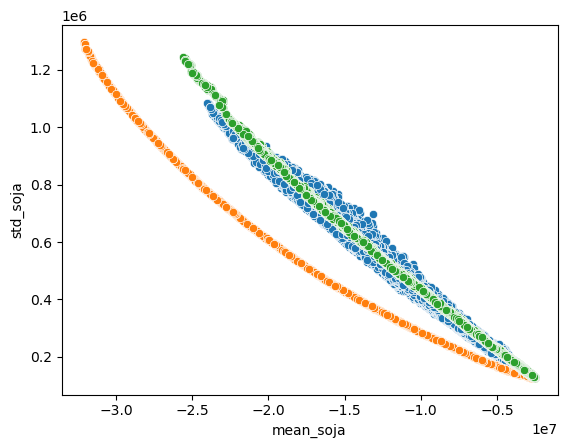

In [7]:
import seaborn as sns
sns.scatterplot(data=df_3, x=df_3.columns[1], y=df_3.columns[2])
sns.scatterplot(data=df_2, x=df_2.columns[1], y=df_2.columns[2])
sns.scatterplot(data=df_3_old, x=df_3_old.columns[1], y=df_3_old.columns[2])

# Compare different settings for NSGA-II
The idea here is to check the final Pareto fronts obtained in two different ways

In [4]:
import pandas as pd

df_classic = pd.read_csv("../results/2024-04-30-soja-allocation-2-objectives-EU27-mean-std/2024-04-30-soja-2-objectives-mean-std-42-archive.csv")
df_strength = pd.read_csv("../results/2024-05-13-soja-allocation-2-objectives-EU27-mean-std/42-population-generation-2179.csv")
df_real_strength = pd.read_csv("../results/2024-05-22-soja-allocation-2-objectives-EU27-mean-std/42-archive.csv")

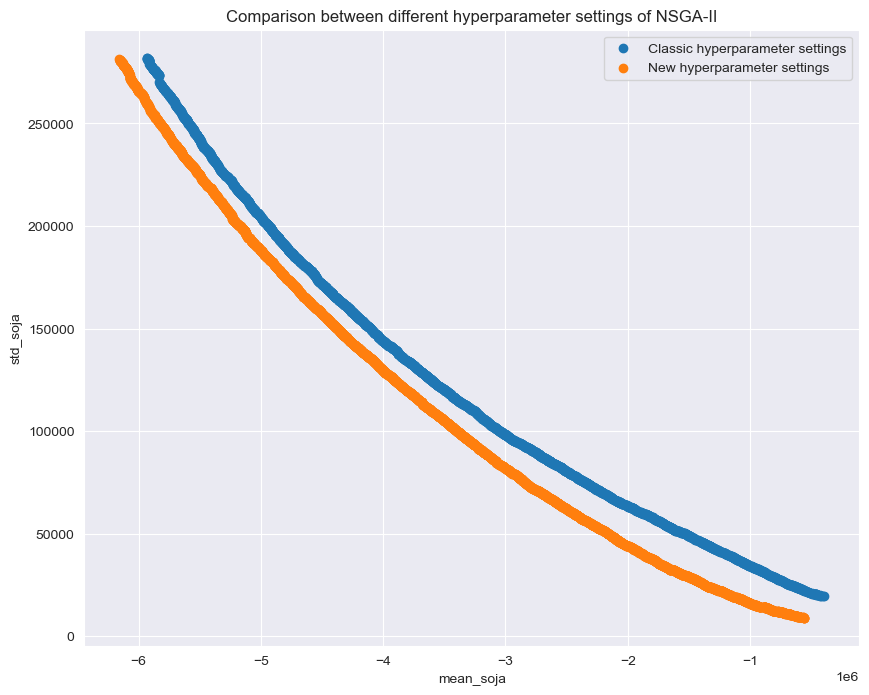

In [6]:
variable_names = ["mean_soja", "std_soja"]
values_classic = df_classic[variable_names].values
values_strength = df_real_strength[variable_names].values

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

fig, ax = plt.subplots(figsize=(10,8))
ax.scatter(values_classic[:,0], values_classic[:,1], label="Classic hyperparameter settings")
ax.scatter(values_strength[:,0], values_strength[:,1], label="New hyperparameter settings")
ax.set_xlabel(variable_names[0])
ax.set_ylabel(variable_names[1])
ax.set_title("Comparison between different hyperparameter settings of NSGA-II")
ax.legend(loc='best')

## Self-contained plots for new comparisons
This part contains all the necessary code to compare different approaches to large-scale crop allocation.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns

sns.set_style('darkgrid')

In [2]:
# load the two files used for comparison
df_qp = pd.read_csv("../results/mean-prod-std-prod-eu42/2024-06-24-qp-mean-std-eu42.csv") # quadratic
df_ea = pd.read_csv("../results/mean-prod-std-prod-eu42/2024-06-04-ea-mean-std-eu42.csv") # EA

# rename and select columns, so that we have coherent plots
df_ea = df_ea[["mean_soja", "std_soja"]]
df_qp.columns = ["mean_soja", "std_soja"]

# also rescale, probably the standard deviation is not correct
#df_qp["std_soja"] = np.power(df_qp["std_soja"].values, 2)

Text(0, 0.5, 'Inter-year standard deviation (Mt)')

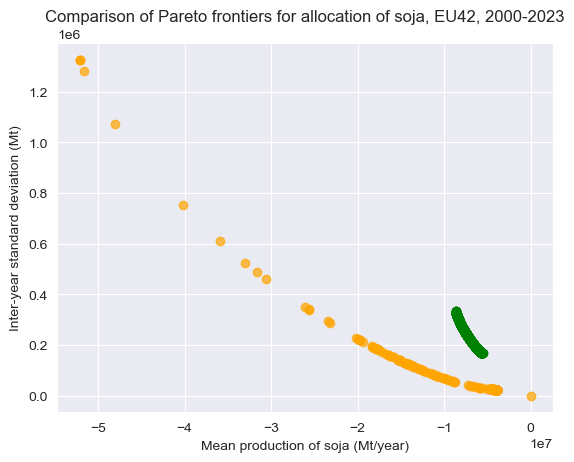

In [3]:
# scatter plots!
fig, ax = plt.subplots()
ax.scatter(df_qp["mean_soja"].values, df_qp["std_soja"].values, color='orange', 
           alpha=0.7, label="Results with Quadratic Programming")
ax.scatter(df_ea["mean_soja"].values, df_ea["std_soja"].values, color='green',
          alpha=0.7, label="Results with Evolutionary Algorithm")
ax.set_title("Comparison of Pareto frontiers for allocation of soja, EU42, 2000-2023")
ax.set_xlabel("Mean production of soja (Mt/year)")
ax.set_ylabel("Inter-year standard deviation (Mt)")

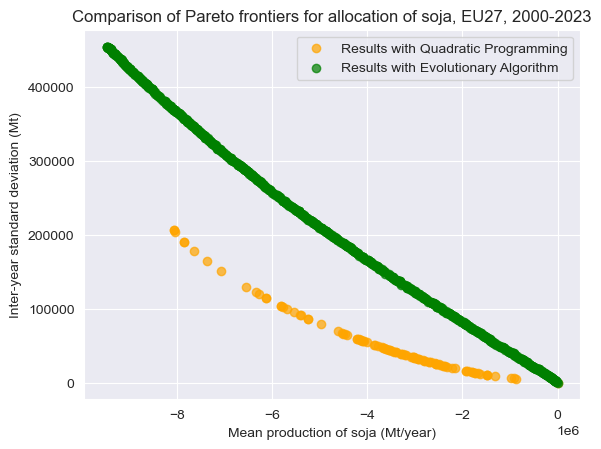

In [5]:
# ok, that was not very good; let's try a comparison on EU27
df_qp = pd.read_csv("../results/mean-prod-std-prod-eu27/2024-06-24-qp-mean-std-eu27.csv")
#df_ea = pd.read_csv("../results/mean-prod-std-prod-eu27/2024-06-22-ea-mean-std-eu27.csv")
#df_ea = pd.read_csv("2024-06-27-soja-allocation-2-objectives-mean-std-eu27/42-archive.csv")
#df_ea = pd.read_csv("../results/mean-prod-std-prod-eu27/2024-06-27-ea-mean-std-eu27-seeding.csv")
#df_ea = pd.read_csv("../results/mean-prod-std-prod-eu27/2024-07-01-ea-mean-std-eu27-seeding-mu6000-population.csv")
df_ea = pd.read_csv("../results/A_nsga2_eu27_pv/42-archive.csv")

# rename and select columns, so that we have coherent plots
df_ea = df_ea[["mean_soja", "std_soja"]]
df_qp.columns = ["mean_soja", "std_soja"]

# scatter plots!
fig, ax = plt.subplots()
ax.scatter(df_qp["mean_soja"].values, df_qp["std_soja"].values, color='orange', 
           alpha=0.7, label="Results with Quadratic Programming")
ax.scatter(df_ea["mean_soja"].values, df_ea["std_soja"].values, color='green',
          alpha=0.7, label="Results with Evolutionary Algorithm")
ax.set_title("Comparison of Pareto frontiers for allocation of soja, EU27, 2000-2023")
ax.set_xlabel("Mean production of soja (Mt/year)")
ax.set_ylabel("Inter-year standard deviation (Mt)")
ax.legend(loc='best')

## Comparison between evolutionary techniques

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')

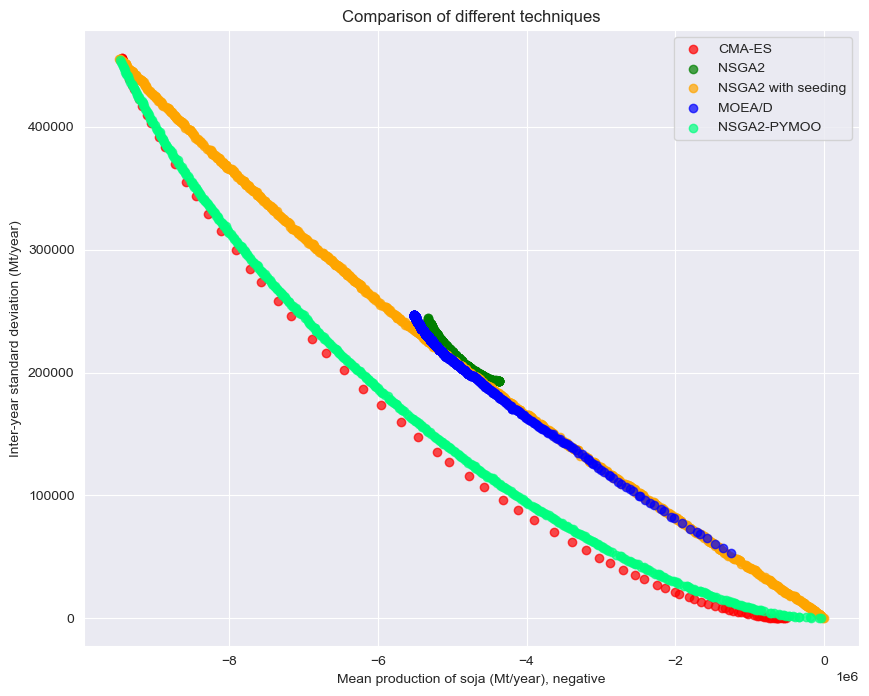

In [7]:
df_cmaes = pd.read_csv("../results/A_nsga2_eu27_pv/cmaes/results.csv")
df_nsga2 = pd.read_csv("../results/A_nsga2_eu27_pv/nsga2-inspyred-mu500-no-seeding/42-archive.csv")
df_nsga2_seeding = pd.read_csv("../results/A_nsga2_eu27_pv/nsga2-inspyred-mu500-seeding/42-archive.csv")
#df_moead = pd.read_csv("../results/A_nsga2_eu27_pv/moead-mu1500-generations100k/results.csv")
df_moead = pd.read_csv("2024-07-31-15-29-07-mean_soja-std_soja-MOEAD/results.csv")
df_nsga2_pymoo = pd.read_csv("../results/A_nsga2_eu27_pv/nsga2-pymoo-mu500-generations10k-no-seeding/results.csv")

fig, ax = plt.subplots(figsize=(10,8))
ax.scatter(df_cmaes["mean_soja"].values * (-1), df_cmaes["std_soja"], color='red', 
           alpha=0.7, label="CMA-ES")
ax.scatter(df_nsga2["mean_soja"].values, df_nsga2["std_soja"].values, color='green', 
           alpha=0.7, label="NSGA2")
ax.scatter(df_nsga2_seeding["mean_soja"].values, df_nsga2_seeding["std_soja"].values, color='orange',
          alpha=0.7, label="NSGA2 with seeding")
ax.scatter(-1 * df_moead["mean_soja"].values, df_moead["std_soja"].values, color='blue', 
           alpha=0.7, label="MOEA/D")
ax.scatter(df_nsga2_pymoo["mean_soja"].values, df_nsga2_pymoo["std_soja"].values, color='springgreen', 
           alpha=0.7, label="NSGA2-PYMOO")
ax.set_title("Comparison of different techniques")
ax.set_xlabel("Mean production of soja (Mt/year), negative")
ax.set_ylabel("Inter-year standard deviation (Mt/year)")
ax.legend(loc='best')